In [105]:
# First attempts at getting a range-doppler map of collected hdf5 data

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift # Might not need this
from radar_ffts import range_doppler_fft, range_doppler_sum

c = 299792458 # metres per second - need this


In [106]:
def get_measurement_parameters(hdf5_file_path):
    freq_slope_const = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/freqSlopeConst'][()] # In MHz per microsecond
    chirp_start_index = hdf5_file_path['Sensors/TI_Radar/Parameters/frameCfg/chirpStartIndex'][()]
    chirp_end_index = hdf5_file_path['Sensors/TI_Radar/Parameters/frameCfg/chirpEndIndex'][()]
    frame_period = hdf5_file_path['Sensors/TI_Radar/Parameters/frameCfg/framePeriod'][()]
    ramp_end_time = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/rampEndTime'][()]
    start_freq = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/startFreq'][()]
    number_of_samples_per_chirp = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/numAdcSamples'][()]
    sample_rate = hdf5_file_path['Sensors/TI_Radar/Parameters/profileCfg/digOutSampleRate'][()] # in ks per second

    Tdata = number_of_samples_per_chirp * 1/(sample_rate*1000)
    # From this we can find bandwidth with B = Tdata * frequency_slope_constant
    bandwidth = Tdata * freq_slope_const * 1e6 * 1e6 # This leaves it in Hz

    # From these we know c and can calculate the range bin size
    range_bin_size = c/(2*bandwidth)
    return freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size

In [107]:
def range_doppler_map(hdf5_file_path, frame, range_bin_size):
    
    frame_data = hdf5_file_path[f'Sensors/TI_Radar/Data/Frame_{frame}/frame_data'] # Collect the data of a specific frame, idk just fucking figure it out
    #print(frame_data[0,:,0]) # data is stored as samples x chirps x channels
    range_pad = 0
    doppler_pad = 0

    fftd_frame_data = range_doppler_fft(frame_data, range_pad, doppler_pad)

    plotted_fftd_frame_data = range_doppler_sum(fftd_frame_data)

#    print(plotted_fftd_frame_data.shape)

    plt.figure()
    plt.imshow(plotted_fftd_frame_data, aspect='auto', cmap='jet')
    plt.title('Range-Doppler Map')
    plt.xlabel('Doppler')
    plt.ylabel('Range')
    plt.colorbar(label='Power (dB)')

    # Get current y-ticks and labels
    y_ticks = plt.gca().get_yticks()
    plt.gca().set_yticklabels(y_ticks[::-1]*range_bin_size) #TODO: How the fuck do I make it so that zero is AT ZERO

    #plt.ylim(0, )

    plt.show()

C:\Users\harry\AppData\Local\Temp\ipykernel_4552\2961899713.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(y_ticks[::-1]*range_bin_size) #TODO: How the fuck do I make it so that zero is AT ZERO


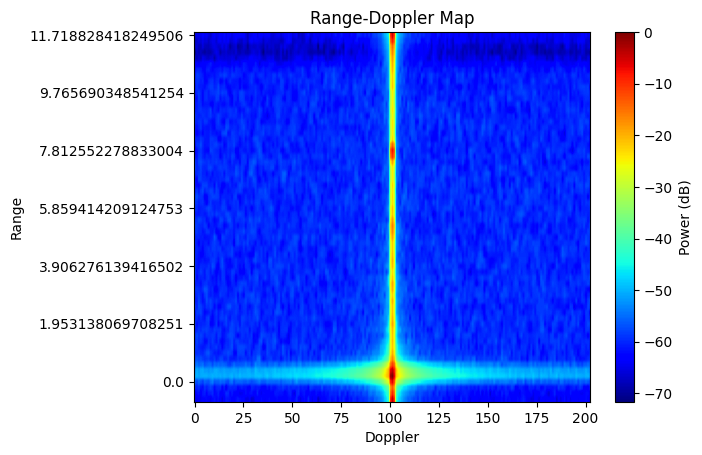

In [111]:
moving_back_test = h5py.File('../4022S_data/undergrad_testset/Experiment_moving_target_back_data.hdf5', 'r') # Read in the file
one_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_1m_1_data.hdf5','r')
two_meter_centre_test = h5py.File('../4022S_data/undergrad_testset/Experiment_stationary_target_2m_1_data.hdf5','r')

freq_slope_const, number_of_samples_per_chirp, sample_rate, Tdata, bandwidth, range_bin_size = get_measurement_parameters(moving_back_test)
range_doppler_map(moving_back_test, '50', range_bin_size)

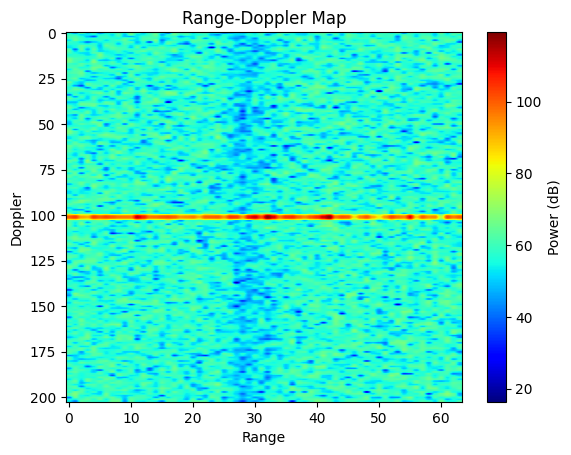

In [110]:
# Trying a homemade range-doppler map - can ignore this
target_frame = 'Sensors/TI_Radar/Data/Frame_0'
frame_data = f[f'{target_frame}/frame_data']#[:,:,0]

window = np.tile(np.hanning(frame_data.shape[1])[np.newaxis, :, np.newaxis], (frame_data.shape[0], 1, frame_data.shape[2]))

after_fast_time_fft = fft(window[:,:,0]*frame_data[:,:,0],frame_data.shape[0],0)
after_slow_time_fft = fftshift(fft(after_fast_time_fft, after_fast_time_fft.shape[1],1))

#Normalize to dB

plt.figure()
plt.imshow(np.rot90(20 * np.log10(np.abs(after_slow_time_fft)), 3), aspect='auto', cmap='jet')
#plt.imshow(20 * np.log10(np.abs(after_slow_time_fft)), aspect='auto', cmap='jet')
plt.title('Range-Doppler Map')
plt.xlabel('Range')
plt.ylabel('Doppler')
plt.colorbar(label='Power (dB)')
plt.show()
